Features shape: (4424, 36)
Targets shape: (4424, 1)
Target columns: Index(['Target'], dtype='object')


,Target
0,Dropout
1,Graduate
2,Dropout
3,Graduate
4,Graduate


Unique target values: ['Dropout' 'Graduate' 'Enrolled']
Train size: (3539, 36) Test size: (885, 36)
Numeric columns: 36
Categorical columns: 0
=== Logistic Regression – Test Performance ===
Accuracy: 0.7288135593220338
              precision    recall  f1-score   support

     Dropout       0.85      0.68      0.76       284
    Enrolled       0.41      0.64      0.50       159
    Graduate       0.86      0.79      0.82       442

    accuracy                           0.73       885
   macro avg       0.70      0.70      0.69       885
weighted avg       0.77      0.73      0.74       885



/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


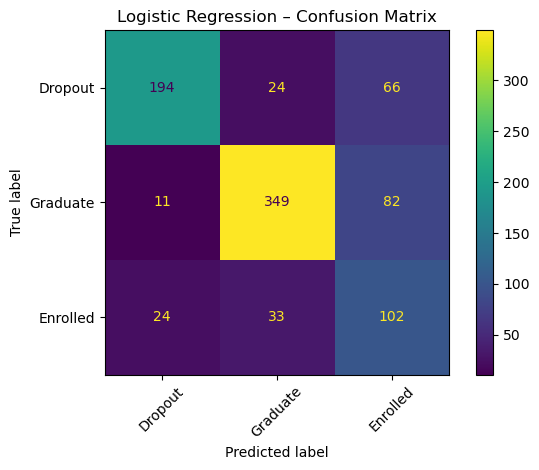

=== Decision Tree – Test Performance ===
Accuracy: 0.6598870056497175
              precision    recall  f1-score   support

     Dropout       0.68      0.64      0.66       284
    Enrolled       0.36      0.43      0.39       159
    Graduate       0.78      0.76      0.77       442

    accuracy                           0.66       885
   macro avg       0.61      0.61      0.61       885
weighted avg       0.67      0.66      0.67       885



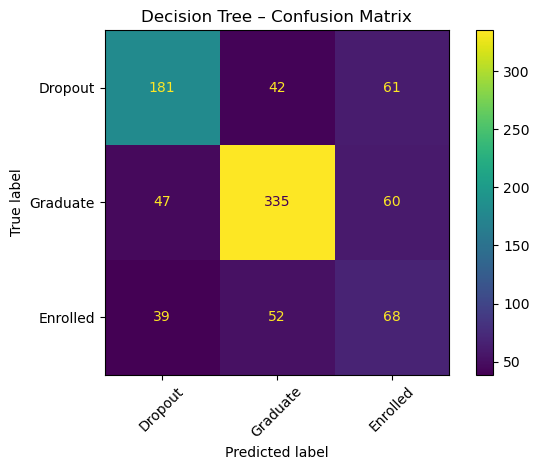

=== Random Forest – Test Performance ===
Accuracy: 0.7672316384180791
              precision    recall  f1-score   support

     Dropout       0.81      0.74      0.77       284
    Enrolled       0.55      0.36      0.43       159
    Graduate       0.79      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.72      0.68      0.69       885
weighted avg       0.75      0.77      0.75       885



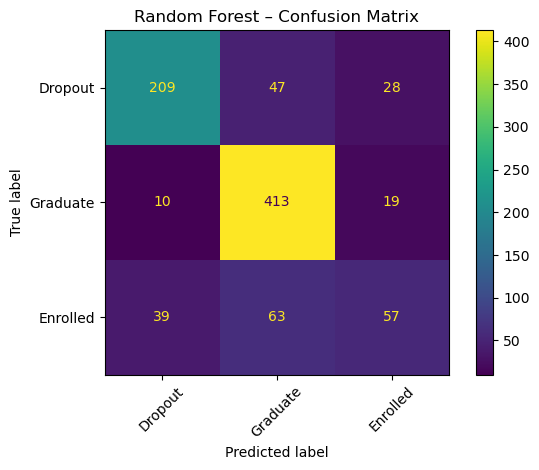

Random Forest 5-fold CV F1 (weighted): [0.74735476 0.77075174 0.75366253 0.76477974 0.76291675]
Mean F1: 0.7598931032713343 Std: 0.008330206614417737


In [ ]:
# %% [markdown]
# # Student Dropout Prediction – Prototype
# Dataset: UCI "Predict Students' Dropout and Academic Success" (ID: 697)

# %%
# 1. Imports

import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo  # pip install ucimlrepo

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

# %%
# 2. Load dataset from UCI

dataset = fetch_ucirepo(id=697)  # Predict Students' Dropout and Academic Success

X = dataset.data.features
y = dataset.data.targets

print("Features shape:", X.shape)
print("Targets shape:", y.shape)
print("Target columns:", y.columns)

# For this dataset, the target column is often named something like 'Target'
# Show first few rows to confirm:
display(y.head())

# %%
# 3. Prepare features (X) and target (y)

# If there is only one target column, convert to 1D array
if y.shape[1] == 1:
    y = y.iloc[:, 0]
else:
    # If there are multiple target columns, pick the main status column
    # Adjust this line to the actual column name if needed
    y = y['Target']  # change if your column is named differently

print("Unique target values:", y.unique())

# %%
# 4. Train-test split (80/20 recommended by dataset authors)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# %%
# 5. Identify numeric and categorical columns

numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))

# %%
# 6. Preprocessing pipeline

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# %%
# 7. Baseline model – Multinomial Logistic Regression

log_reg = LogisticRegression(
    multi_class="multinomial",
    max_iter=1000,
    class_weight="balanced"  # handle class imbalance
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", log_reg)
])

log_reg_clf.fit(X_train, y_train)

y_pred_log = log_reg_clf.predict(X_test)

print("=== Logistic Regression – Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log, labels=y.unique())
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=y.unique())
disp_log.plot(xticks_rotation=45)
plt.title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()


# 8. Advanced model – Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("=== Random Forest – Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=y.unique())
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=y.unique())
disp_rf.plot(xticks_rotation=45)
plt.title("Random Forest – Confusion Matrix")
plt.tight_layout()
plt.show()

# %%
# 9. Cross-validation on training set (optional, for robustness)

cv_scores = cross_val_score(
    rf_clf,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

print("Random Forest 5-fold CV F1 (weighted):", cv_scores)
print("Mean F1:", cv_scores.mean(), "Std:", cv_scores.std())
